<a href="https://colab.research.google.com/github/jazbengu/COS711-ASSIGNMENT-TWO/blob/main/Joy_Bengu_25000307_COS711_Assignment_Two_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --force-reinstall scikeras
!pip install --force-reinstall tensorflow
!pip install --force-reinstall keras
!pip install --force-reinstall numpy
!pip install --force-reinstall seaborn
!pip install --force-reinstall pandas

#print(tf.__version__)



  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached rich-13.9.2-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached h5py-3.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached optree-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (47 kB)
  Using cached ml_dtypes-0.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.m

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Optimizer
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt




In [2]:

def load_data(file_path):
    data = pd.read_csv(file_path)
    imputer = SimpleImputer(strategy='mean')
    data.iloc[:, :-1] = imputer.fit_transform(data.iloc[:, :-1])  # Assuming last column is labels

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    y = pd.get_dummies(y).values

    return X, y

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


In [3]:
class ConstantLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def __call__(self, step):
        return self.learning_rate

class RProp(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, eta_plus=1.2, eta_minus=0.5, delta_min=1e-6, delta_max=50, **kwargs):
        learning_rate = ConstantLearningRateSchedule(learning_rate)
        kwargs['learning_rate'] = learning_rate
        super(RProp, self).__init__(**kwargs)
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max
        self.prev_grads = {}
        self.deltas = {}

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'prev_grad')
            self.add_slot(var, 'delta')

    def apply_gradients(self, grads_and_vars):
        for gradient, variable in grads_and_vars:
            variable_id = id(variable)
            if variable_id not in self.prev_grads:
                self.prev_grads[variable_id] = tf.Variable(gradient)
                self.deltas[variable_id] = tf.Variable(self.delta_min * tf.ones_like(variable))
            else:
                prev_grad = self.prev_grads[variable_id]
                delta = self.deltas[variable_id]
                sign_product = tf.math.reduce_sum(tf.math.sign(gradient) * tf.math.sign(prev_grad))
                delta_update = tf.cond(sign_product > 0, lambda: tf.math.minimum(delta * self.eta_plus, self.delta_max), lambda: tf.math.maximum(delta * self.eta_minus, self.delta_min))
                delta.assign(delta_update)
                variable.assign(variable - tf.math.sign(gradient) * delta)
                self.prev_grads[variable_id].assign(gradient)

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(RProp, self)._prepare_local(var_device, var_dtype, apply_state)

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RProp, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # Compute the update to 'var' given the gradient.
        # This will produce a tensor of dtype var_dtype.
        delta = self.get_slot(var, 'delta')
        prev_grad = self.get_slot(var, 'prev_grad')
        grad = tf.convert_to_tensor(grad, dtype=var_dtype.base_dtype)
        prev_grad.assign(grad)
        delta.assign(tf.where(tf.multiply(grad, prev_grad) > 0,
                              tf.minimum(delta * self.eta_plus, self.delta_max),
                              tf.maximum(delta * self.eta_minus, self.delta_min)))
        new_var = var - tf.multiply(tf.sign(grad), delta)
        var.assign(new_var)
        return tf.group(*[var.assign(new_var)])

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # Compute the update to 'var' given the gradient.
        # This will produce a tensor of dtype var_dtype.
        delta = self.get_slot(var, 'delta')
        prev_grad = self.get_slot(var, 'prev_grad')
        grad = tf.convert_to_tensor(grad, dtype=var_dtype.base_dtype)
        prev_grad.assign(grad)
        delta.assign(tf.where(tf.multiply(grad, prev_grad) > 0,
                              tf.minimum(delta * self.eta_plus, self.delta_max),
                              tf.maximum(delta * self.eta_minus, self.delta_min)))
        new_var = var.assign(tf.IndexedSlices(tf.multiply(tf.sign(grad), delta), indices, var.shape))
        return tf.group(*[var.assign(new_var)])

    def get_config(self):
        base_config = super(RProp, self).get_config()
        return {
            **base_config,
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'eta_plus': self.eta_plus,
            'eta_minus': self.eta_minus,
            'delta_min': self.delta_min,
            'delta_max': self.delta_max,
        }

In [4]:
def create_model(optimizer='adam', learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_dim=13, activation=activation))  #13 feature but the last feature is Type
    model.add(Dense(64, activation=activation))
    model.add(Dense(3, activation='softmax'))

    #we now initialize the optimizer based on the chosen or default optimizer type
    if optimizer == 'adam':
        learning_rate = learning_rate or 0.001 #giving a default learning rate for ADAM if there wasn't one already given
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        learning_rate = learning_rate or 0.001 #giving learning rate a default value for ADAM if there wasn't one already given
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rprop':
       opt = RProp(learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [5]:
from scikeras.wrappers import KerasClassifier
def perform_grid_search(X_train, y_train):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    param_grid = {
        'batch_size': [5, 10, 15,20],
        'epochs': [5, 10, 15]
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)

    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


    results_df = pd.DataFrame(grid_result.cv_results_)
    results_pivot = results_df.pivot_table(index='param_batch_size', columns='param_epochs', values='mean_test_score')

    plt.figure(figsize=(8, 6))
    sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Hyperparameter Tuning: Batch Size vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Batch Size")
    plt.show()

    return grid_result.best_estimator_

In [6]:
def train_and_compare_algorithms(X_train, y_train, X_test, y_test):
    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    history_adam = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    history_sgd = sgd_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    rprop_model = create_model(optimizer='rprop')
    history_rprop = rprop_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    plt.plot(history_adam.history['val_loss'], label='Adam')
    plt.plot(history_sgd.history['val_loss'], label='SGD')
    plt.plot(history_rprop.history['val_loss'], label='Rprop')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()




In [26]:
def hybrid_learning(X_train, y_train, X_test, y_test):

    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    adam_history = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, verbose=0)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    sgd_history = sgd_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, verbose=0)

    rprop_model = create_model(optimizer='rprop')
    rprop_history = rprop_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, verbose=0)

    adam_pred = adam_model.predict(X_test)
    sgd_pred = sgd_model.predict(X_test)
    rprop_pred = rprop_model.predict(X_test)

    ensemble_pred = (adam_pred + sgd_pred + rprop_pred) / 3
    ensemble_pred = np.argmax(ensemble_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(ensemble_pred == y_test_labels)

    print(f"Hybrid model accuracy: {accuracy}")
    # Plot the performance of individual optimizers and the hybrid model
    plt.plot(adam_history.history['val_loss'], label='Adam')
    plt.plot(sgd_history.history['val_loss'], label='SGD')
    plt.plot(rprop_history.history['val_loss'], label='RProp')
    plt.plot([np.mean(adam_history.history['val_loss'])]*20, label='Adam Mean', linestyle='--')
    plt.plot([np.mean(sgd_history.history['val_loss'])]*20, label='SGD Mean', linestyle='--')
    plt.plot([np.mean(rprop_history.history['val_loss'])]*20, label='RProp Mean', linestyle='--')
    plt.plot([accuracy]*20, label='Hybrid Model', linestyle='--')
    plt.title('Validation Loss Comparison With Hybrid')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.9696647552777957 using {'batch_size': 5, 'epochs': 15}


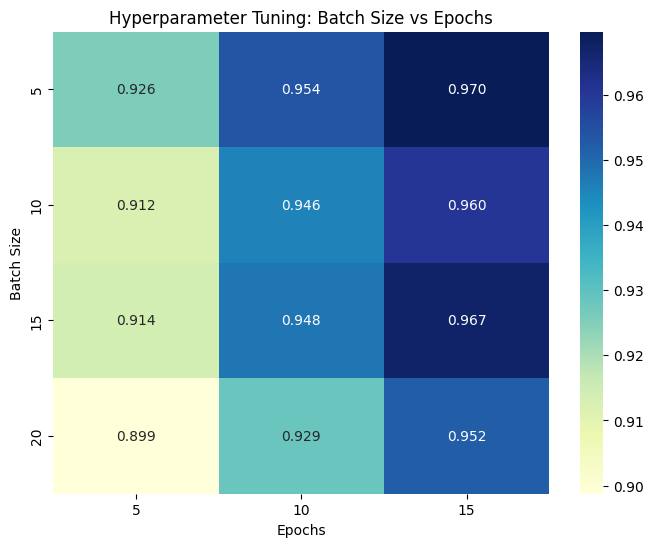

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6643 - loss: 0.8339 - val_accuracy: 0.7968 - val_loss: 0.5407
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8058 - loss: 0.5295 - val_accuracy: 0.8485 - val_loss: 0.4120
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8599 - loss: 0.3880 - val_accuracy: 0.9091 - val_loss: 0.3319
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8945 - loss: 0.3142 - val_accuracy: 0.9020 - val_loss: 0.2630
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9096 - loss: 0.2670 - val_accuracy: 0.9251 - val_loss: 0.2463
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9351 - loss: 0.2129 - val_accuracy: 0.9144 - val_loss: 0.2093
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9459 - loss: 0.1670 - val_accuracy: 0.9394 - val_loss: 0.1754
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9576 - loss: 0.1414 - val_accuracy: 0.9430 - val_

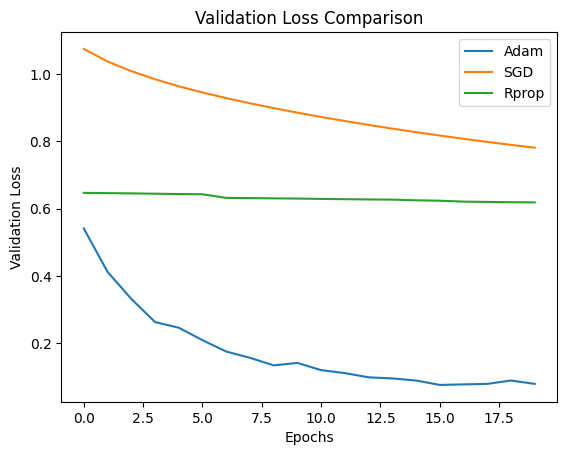

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Hybrid model accuracy: 0.9500891265597148


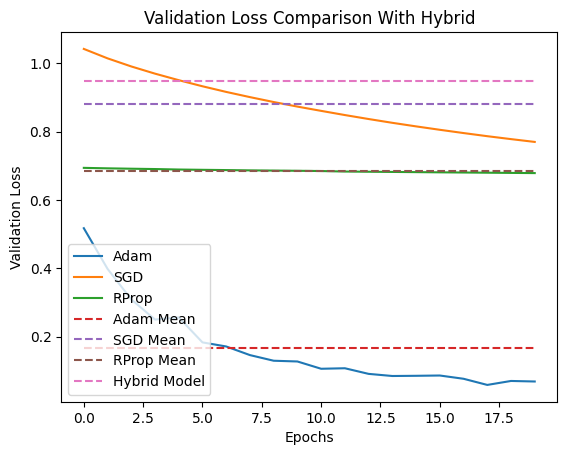

In [35]:
def main():
    X, y = load_data('Almond.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = preprocess_data(X_train, X_test)

    best_model = perform_grid_search(X_train, y_train)
    train_and_compare_algorithms(X_train, y_train, X_test, y_test)
    hybrid_learning(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()